In [1]:
# 라이브러리 세팅
from catboost import CatBoostClassifier, Pool
import pandas as pd
import matplotlib.pyplot as plt

# 글씨체 오류
import matplotlib.font_manager as fm
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 디렉토리 세팅
dir = "/Users/hj/projects/Aimers/data/processed/"
# 전처리 완료된 데이터가 저장된 디렉토리
dir_to_submit = "/Users/hj/projects/Aimers/submission/"     # submission 파일들이 저장된 디렉토리(sampli submission 포함)
name = 'hj'                   # 이름

In [3]:
# 모델 불러오기
from_file = CatBoostClassifier()
model = from_file.load_model('final_model')

# 데이터 불러오기 
train = pd.read_csv(dir + "train_Preprocessed.csv", index_col=0)
X, y = train.drop(columns = ['임신 성공 여부']), train['임신 성공 여부']

# Pool 객체 만들기
cat_cols = ['시술 시기 코드', '시술 당시 나이', '시술 유형', '총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수', 'DI 시술 횟수', '총 임신 횟수', 'IVF 임신 횟수', 'DI 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수', 'DI 출산 횟수', '난자 출처', '정자 출처', '난자 기증자 나이', '정자 기증자 나이']
X[cat_cols] = X[cat_cols].fillna("Unknown") # 결측이 있으면 안됨
pool = Pool(X, y, cat_features= cat_cols)

In [4]:
# 칼럼 명 불러오기 : get_cat_feature_indices() , feature_names_[i]
cat_idx = model.get_cat_feature_indices()
cat_names = [model.feature_names_[i] for i in cat_idx]
col_names = [model.feature_names_[i] for i in range(X.shape[1])]
print(cat_names)

['시술 시기 코드', '시술 당시 나이', '시술 유형', '총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수', 'DI 시술 횟수', '총 임신 횟수', 'IVF 임신 횟수', 'DI 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수', 'DI 출산 횟수', '난자 출처', '정자 출처', '난자 기증자 나이', '정자 기증자 나이']


In [5]:
# 궁금한 칼럼명 찾기
target_idx = [58, 33, 44, 38]
target_names = [model.feature_names_[i] for i in target_idx]
print(target_names)

['배아 이식 경과일', '총 생성 배아 수', '파트너 정자와 혼합된 난자 수', '저장된 배아 수']


### 트리

In [6]:
# pip install graphviz : 설치 필요
model.tree_count_ # 트리의 개수 (iteration 수와 같은 듯)

2000

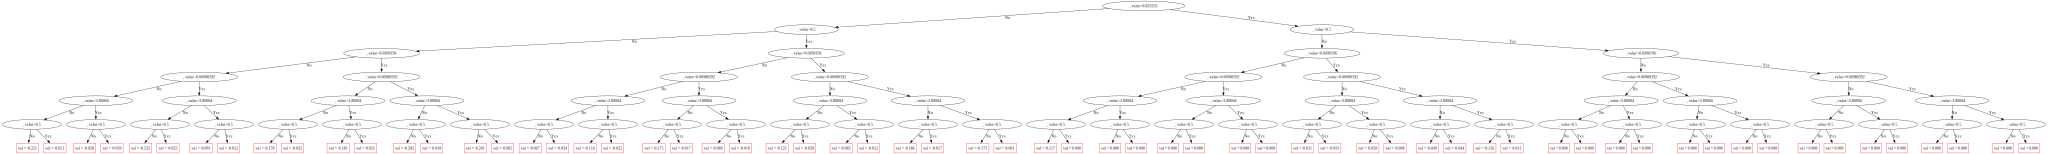

In [7]:
# 트리 이미지로 저장 
tree_graph = model.plot_tree(tree_idx=1, pool = pool) # tree_idx에 따라 다른 tree가 나옴
tree_graph.graph_attr.update(size="40", dpi="600") # 그래프 사이즈, 해상도
tree_graph.node_attr.update(fontsize="10") # 폰트 조절
tree_graph.render("tree_1", format="png", cleanup=True) # 파일명 

model.plot_tree(tree_idx=1, pool = pool)

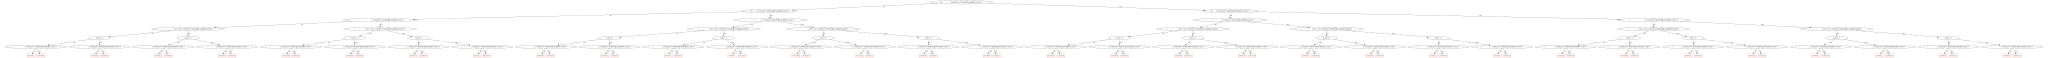

In [8]:
# 1000번째 tree
model.plot_tree(tree_idx=1000, pool = pool)

- 트리마다 기준이 크게 달라진다 -> Gradient Boosting이라서 그런듯 
- 초반 tree vs 후반 tree 중 무엇이 중요한지 생각해봐야할 듯 

- tree 결과 : 예측값을 대부분 0에 가깝다. 매우 보수적으로 예측하는듯

### Feature Importance

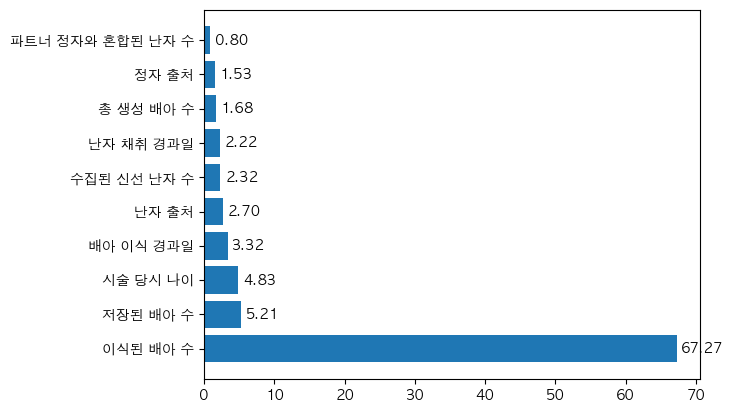

In [9]:
# 1. Prediction Values Change

q = len(model.get_feature_importance()) # 변수의 개수
col_names = [model.feature_names_[i] for i in range(q)]
feature_importances = model.get_feature_importance()

# 데이터프레임
df_importance = pd.DataFrame({
      'Feature' : col_names,
    'Importance' : feature_importances
}).sort_values(by = 'Importance', ascending= False)

# Prediction Values Change : 각 특징이 예측값에 미치는 평균 변화량 기준
top10 = df_importance.head(10)
bars = plt.barh(top10['Feature'], top10['Importance'])

# 각 바 위에 중요도 값 표시 (소수점 두 자리까지)
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01 * max(top10['Importance']),   # 약간 오른쪽으로 오프셋
             bar.get_y() + bar.get_height() / 2,
             f'{width:.2f}',
             va='center', ha='left', fontsize=10)

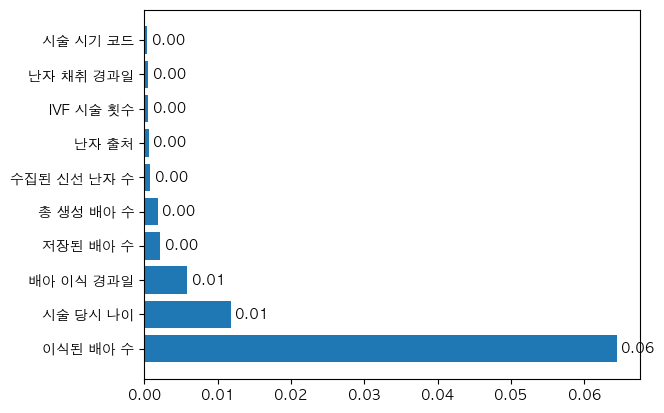

In [10]:
# 2. LossFunctionChange 
#   : 피처의 값을 무작위로 섞었을 때 모델의 loss function에 얼마나 변화하는지 측정 
q = len(model.get_feature_importance()) # 변수의 개수
col_names = [model.feature_names_[i] for i in range(q)]
feature_importances = model.get_feature_importance(pool, type = 'LossFunctionChange')

# 데이터프레임
df_importance = pd.DataFrame({
      'Feature' : col_names,
    'Importance' : feature_importances
}).sort_values(by = 'Importance', ascending= False)

# Prediction Values Change : 각 특징이 예측값에 미치는 평균 변화량 기준
top10 = df_importance.head(10)
bars = plt.barh(top10['Feature'], top10['Importance'])

# 각 바 위에 중요도 값 표시 (소수점 두 자리까지)
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01 * max(top10['Importance']),   # 약간 오른쪽으로 오프셋
             bar.get_y() + bar.get_height() / 2,
             f'{width:.2f}',
             va='center', ha='left', fontsize=10)

#### 3. SHAP

- SHAP (Shapley Additive exPlanations) 
- 게임 이론에서 유래해서 각 피처를 플레이어로 보고, 각 피처가 예측 결과에 기여한 공헌도를 분배하는 방식으로 제공 
- SHAP 값이 양수 : 해당 피처가 예측 결과를 증가시키는 방향으로 기여했다는 것 (음수면 감소시키는 방향)

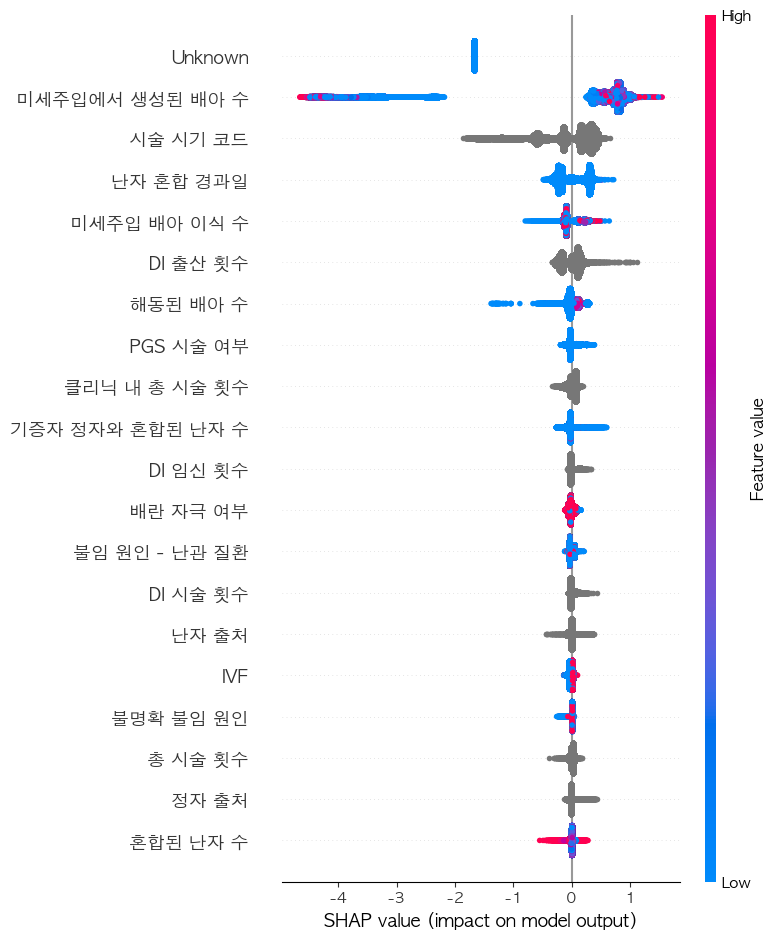

In [11]:
import shap

# SHAP 값 계산 시 주의: 모델에 따라 bias 값 처리가 필요할 수 있음.
shap_values = model.get_feature_importance(pool, type="ShapValues")[:, 1:]

# 원본 DataFrame과 변수명(col_names)을 그대로 전달
shap.summary_plot(shap_values, X, feature_names=col_names)

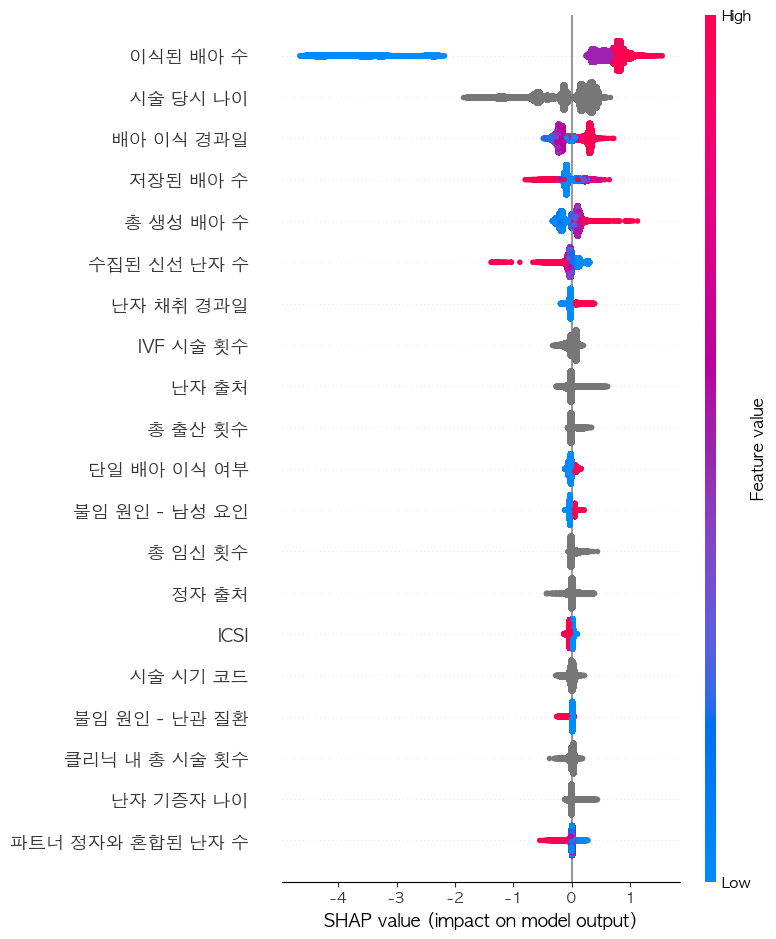

In [12]:
import shap

# TreeExplainer를 사용하여 SHAP 값 계산
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)  # 이진 분류라면 shape: (n_samples, n_features)

# SHAP summary plot (산점도)
shap.summary_plot(shap_values, X, feature_names=col_names)

##### dependece_plot : 변수 간 상관성 확인 가능

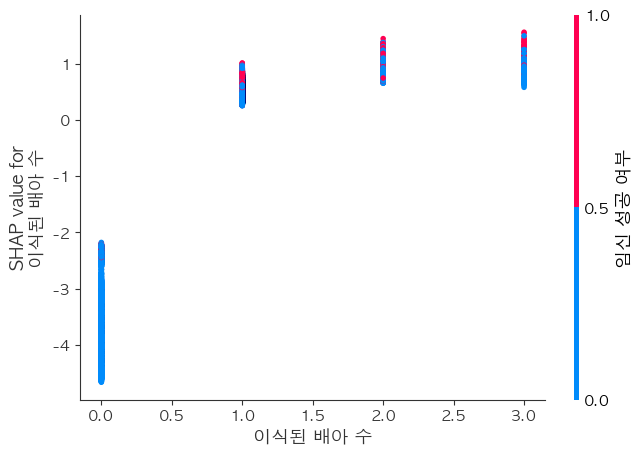

In [14]:
X_plot = X.copy()
X_plot['임신 성공 여부'] = y

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_plot)

shap.dependence_plot("이식된 배아 수", 
                     shap_values, 
                     X_plot, 
                     feature_names= X_plot.columns, 
                     interaction_index= '임신 성공 여부')

##### Force Plot : 개별 샘플에서 각 피처의 영향력 확인 가능

In [ ]:
# 3. Force Plot

shap.initjs() # JavaScript 기반 시각화를 위해 초기화 
sample_index = 1 # 샘플의 인덱스 
shap.force_plot(explainer.expected_value, shap_values[sample_index, :], X.iloc[sample_index, :], feature_names= col_names)

#### decion plot

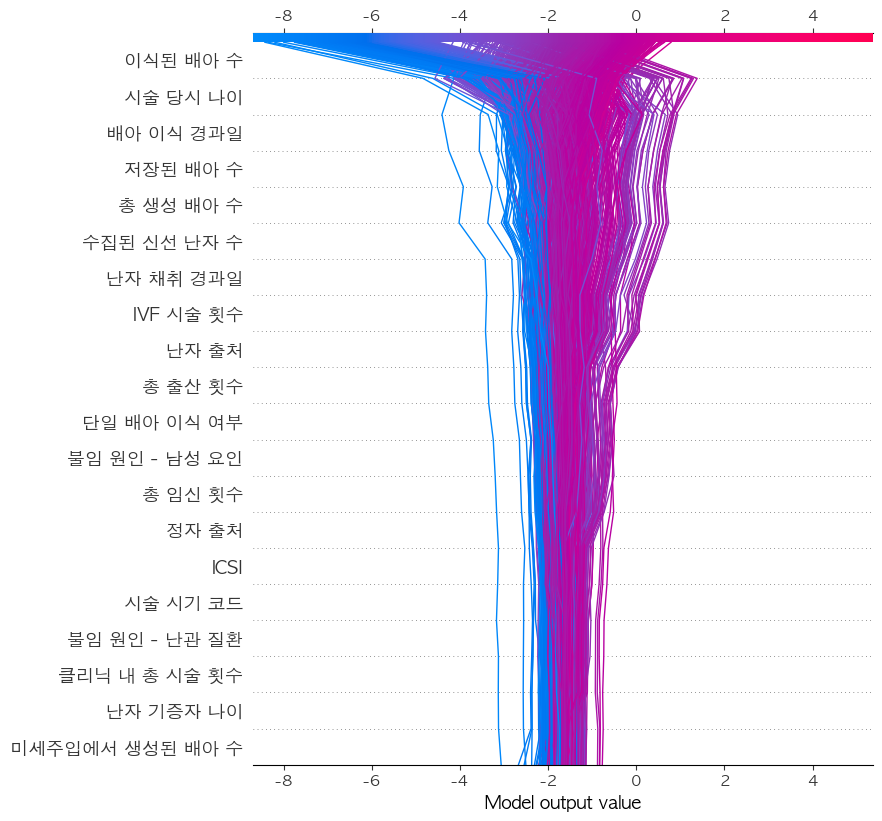

In [98]:
import numpy as np
import shap

# 너무 많아서 샘플링 해서 확인 
sample_size = 2000
np.random.seed(42)
sample_indices = np.random.choice(np.arange(X.shape[0]), size=sample_size, replace=False)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

if hasattr(X, "iloc"):
    X_sub = X.iloc[sample_indices]
else:
    X_sub = X[sample_indices]
shap_values_sub = shap_values[sample_indices]

# decision plot 그리기
shap.decision_plot(explainer.expected_value, shap_values_sub, X_sub, feature_names=col_names)

#### 피처 중요도 결론 

이상치, 결측치 대체 및 파생 변수 생성에 우선 순위를 둬야 하는 변수들 : 


1. 이식된 배아 수 
2. 시술 당시 나이 
3. 저장된 배아 수 
4. 배아 이식 경과일 
5. 총 생성 배아 수 

6. 수집된 신선 난자 수
7. 난자 채취 결과일

### 주요 변수 이상치, 결측치 대체 

In [17]:
dir = "/Users/hj/projects/Aimers/data/raw/"             # raw data의 디렉토리
dir_to_save = "/Users/hj/projects/Aimers/data/processed/"     # 전처리 완료된 데이터를 저장할 디렉토리

train = pd.read_csv(dir + 'train.csv').drop(columns=['ID'])
test = pd.read_csv(dir + 'test.csv').drop(columns=['ID'])

#### 이식된 배아 수

In [18]:
imp_cols = ['이식된 배아 수', '시술 당시 나이', '저장된 배아 수', '배아 이식 경과일']

In [20]:
from summarytools import dfSummary

train_imp = train[imp_cols]
dfSummary(train_imp)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,이식된 배아 수[float64],1. 2.02. 1.03. 0.04. 3.05. nan,"110,845 (43.2%)93,791 (36.6%)36,544 (14.3%)8,880 (3.5%)6,291 (2.5%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABzCAYAAACPdnBjAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAiVJREFUeJzt20GK02AAhuFUiuimZSj0MD2Eh/UQvU2RduGIm0pwpUsxb9LkeRazbWd4SSbh/3bP53OAwofkU0BslMRGZjcMw+dhGD52H7loP5/P5/vcX2Kt9qfT6cvhcHib+4sswePx+Lbb7b4Kbhr7MbTL5fJ+PB5/DBt2v98/Xa/Xt9vtNl7lxTaB/fhjDO18Pn+f4gNezPgvBRPxgEBGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZ76mM8XjNsnL/B9PbjgcHxHJfjNb8PT46ndef+HmvlWPifHAuf0M5ulIoHBDJbuY26PS7AJtZVVlPLsPp1ldXUcmxlXbX51zpL4AGBjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzOrXVWv+3V7NJtZVVlPL4Fg4GesqMh4QWMVt1K2LZl1l0USyrrJool5XrfZVCv/GAwIZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERuvva6yaCJdV1k08TfHwslYVzH7lc1ViWbwYqxCMngxVqEevBir8N95qUtGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbMy3rrKMIl1XWUYxBRsEMtZVzHplc1WjWVdZVpGsqyyrqNdVllVMwktdMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmJjnnWVZRXpusqyiqnYIJCxriLjAYGM2BgqvwDHMQ43+lIxcgAAAABJRU5ErkJggg=="">","6,291(2.5%)"
2,시술 당시 나이[object],1. 만18-34세2. 만35-37세3. 만38-39세4. 만40-42세5. 만43-44세6. 만45-50세7. 알 수 없음,"102,476 (40.0%)57,780 (22.5%)39,247 (15.3%)37,348 (14.6%)12,253 (4.8%)6,918 (2.7%)329 (0.1%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAChCAYAAADQgM1HAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAArlJREFUeJzt281tE1EARtE3kcXPJlEUKSVADymCYikiRdCDhZwFATZGswiigOR6mHfOgq0d6WqGZ71vOZ/PAwpXyaeA2CiJjYzYyIiNzDLG+DjGeDfm8/t8Pj9f+kvM5HB3d/fl+vr6dkzm6enp+7IsXwXXOayhPTw8PN/c3PwckzidTh8eHx9vj8fj+kQXW+Sw/rOGdn9//2PMZf3vAyEHBDJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNtpbH+uVmzGR2f7erTislwjXu12zXblZ/+71tu6lv8dMXAsns1jEM+uTzdNmxzY1eDFC2bfNDF6MUPZva4OXqU7Es/GjLhmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxMd+6agvfgYnWVRZP+2aDQMa6il092TytaNZVFlMk6yqLKep11cVPuWyDH3XJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjYx+DFiIV08GLEwgvXwskYvJBxQGA3r1GvUJp1lWUVybrKsop6XWVZxV8OCGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbPz/6yrLKtJ1lWUV/3ItnIx1FZt5snky0QxeDFZIBi8GK9SDF4MVXo0fdcmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2Lj84MVghXTwYrDCa3ItnIzBCxkHBC76GvXqpFlXWVSRrKssqqjXVRZVvAkHBDJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNi6zrrKoIl1XWVTxVlwLJ2NdRcYBgczVsiyfl2VxMCB5sn0aY7x/+49idl6jZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEYa27cxxq/uI5mVwQsZr1EyYiMjNjJiIyM2RuUPdmpJBancjtsAAAAASUVORK5CYII="">",0(0.0%)
3,저장된 배아 수[float64],Mean (sd) : 1.2 (2.5)min < med < max:0.0 < 0.0 < 51.0IQR (CV) : 2.0 (0.5),42 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAcFJREFUeJzt18FOwkAURuG5Fkh1UUIwZccjuGDJQ/iwbF2S8DYNdFIslpAxs3NjpINV/3i+dedmkp7cgoUQHPDX3f32BYBrjL56wMzunXMTl6YLIbSJZ4HrQo2Rzufz56IoZi6B935vZhtixdAbdRIjXa/X7XQ6PfUZXNd1vtvtZlVVxW1MqBj20x/FSMuyfE2YH382ADfjzxQkECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokjIYcfrlcxs65wsxSR3QhhPZ7bwVFg4V6PB7H5/P5ablcZlmWnVJmeO/3ZrYhVgwWatd1ozzPH1ar1WmxWOz7nq/rOt9ut2VVVY9m5lOuQOD/LNQYTd/BTdP0PvNR27Y3beTD4dCY2YtzLmmbw/20txDCp+/qHd8MY24abkOzAAAAAElFTkSuQmCC"">","6,291(2.5%)"
4,배아 이식 경과일[float64],1. 5.02. 3.03. nan4. 2.05. 0.06. 1.07. 4.08. 6.09. 7.0,"81,459 (31.8%)57,924 (22.6%)43,566 (17.0%)35,078 (13.7%)24,904 (9.7%)6,053 (2.4%)4,504 (1.8%)2,773 (1.1%)90 (0.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAADPCAYAAADifqNtAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAA35JREFUeJzt3UFqG2cAhuF/jEmrjY0x+AjtzgfwIXLYHsIH8LJ3MMFeVG03CkNaSGlxUpJ5NSM9DyTglRV4+RUN/2dPh8NhQOEi+S4g

In [21]:
train_processed_imp = X[imp_cols]
dfSummary(train_processed_imp)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,이식된 배아 수[float64],1. 2.02. 1.03. 0.04. 3.0,"110,041 (43.6%)93,263 (37.0%)40,226 (15.9%)8,825 (3.5%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABcCAYAAAB5jMeAAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAdhJREFUeJzt2zFu2mAAhmG7QlW7gCIkDsMhetgegtugCoam6uLK6tilA7x2zPMMGWOCXpkY/d84TdMAhU/JVUBslMZhGL4Ow/A5veq6/Z6m6X3pF7FFu+Px+G2/378t/ULW4n6//xjH8bvgHm83h3Y+n98Ph8Ov4cXdbrcvl8vl7Xq9znd6sT3Ybv4xh3Y6nX4++pd/UPO/FTyBBwQyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzbaUx/z0ZrukuvlfXiu3XxYcD7D5WjNX/P7MZ/WXfp1bJFj4f9yLPxJRlM+Kh4QyLzKx6iPxhV4iXWVxdQ6bH5dZTG1Hq+yrvK1zgp4QCAjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjKbn/Jt+W/7aF5iymeetw42CGRM+djcnc2dhWZdZd1Esq6ybqJeV232SZf/50tdMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmJjO+sq6ybSdZV1EzMbBDLWVSx+Z3MnollXWUORrKusoajXVdZQPJwvdcmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjeXWVdZQpOsqayiewQaBjHUVGQ8IDJU/s1jYubMXOFwAAAAASUVORK5CYII="">",0(0.0%)
2,시술 당시 나이[object],1. 만18-34세2. 만35-37세3. 만38-39세4. 만40-42세5. 만43-44세6. 만45-50세7. Unknown,"101,247 (40.1%)56,991 (22.6%)38,681 (15.3%)36,689 (14.5%)11,927 (4.7%)6,570 (2.6%)250 (0.1%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAChCAYAAADQgM1HAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAArlJREFUeJzt281tE1EARtE3kcXPJlEUKSVADymCYikiRdCDhZwFATZGswiigOR6mHfOgq0d6WqGZ71vOZ/PAwpXyaeA2CiJjYzYyIiNzDLG+DjGeDfm8/t8Pj9f+kvM5HB3d/fl+vr6dkzm6enp+7IsXwXXOayhPTw8PN/c3PwckzidTh8eHx9vj8fj+kQXW+Sw/rOGdn9//2PMZf3vAyEHBDJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNtpbH+uVmzGR2f7erTislwjXu12zXblZ/+71tu6lv8dMXAsns1jEM+uTzdNmxzY1eDFC2bfNDF6MUPZva4OXqU7Es/GjLhmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxMd+6agvfgYnWVRZP+2aDQMa6il092TytaNZVFlMk6yqLKep11cVPuWyDH3XJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjYx+DFiIV08GLEwgvXwskYvJBxQGA3r1GvUJp1lWUVybrKsop6XWVZxV8OCGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbPz/6yrLKtJ1lWUV/3ItnIx1FZt5snky0QxeDFZIBi8GK9SDF4MVXo0fdcmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2Lj84MVghXTwYrDCa3ItnIzBCxkHBC76GvXqpFlXWVSRrKssqqjXVRZVvAkHBDJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNi6zrrKoIl1XWVTxVlwLJ2NdRcYBgczVsiyfl2VxMCB5sn0aY7x/+49idl6jZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEYa27cxxq/uI5mVwQsZr1EyYiMjNjJiIyM2RuUPdmpJBancjtsAAAAASUVORK5CYII="">",0(0.0%)
3,저장된 배아 수[float64],Mean (sd) : 0.0 (0.0)min < med < max:0.0 < 0.0 < 0.6IQR (CV) : 0.0 (0.5),30 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAfpJREFUeJzt2MFqwkAURuG51UqqoIgl7nyELlz6EH1Yt10KeRhh0ATT2IhMme5L69hQ//Z8a2cY9JAx10IIDrh1d799AOA7+l99wMwenHMDl6YNITSJa4HvhRojnc1mz+PxeOoSVFW1M7M1saLrJ+ogRrparZrJZHK8ZOOyLLOiKKbe+/g0JlR0e/VHMdI8z18T9o9/G4Cr8TIFCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCf0uNz+fz/fOubGZpW7RhhCanz0VFHUWal3X96fT6WmxWPR6vd4xZY+qqnZmtiZWdBZq27b9LMuGy+XyOJ/Pd5euL8syK4pi6r0fOOcI9Z/r9OqPRqPRMc/z18TlDz98HIjiZQoSCBUSOr/6f3FqwMTgD7nZUK+dGjAx+FtuNtRrpgZxYrDZbHLv/aOZValHIHKxUOMPf+nGh8PhY01d19l2ux2mrk/RNM3VM9z9fn8wsxfnXNJ6uEu9hRA+/a7fAWu8lQXVvyH4AAAAAElFTkSuQmCC"">",0(0.0%)
4,배아 이식 경과일[float64],Mean (sd) : 3.3 (1.7)min < med < max:-0.4 < 3.0 < 9.4IQR (CV) : 3.0 (2.0),"11,030 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAllJREFUeJzt3UFu2kAYhmFP7UQuSEYICXZcIFIXLDlED9sjdMEJuAE7JGSBcOJgjKupVKmt0gp7Yphv8j7rTIKSVzj/JGObpmkiwHef7v0CgGskV30UWjHGfI6i6LHj8lPTNC/v/JLkEWoPkU4mk69Zlo27rD8cDrkx5hux/olQ39+jjXS5XL6MRqOyzcL9fp+uVqvxbrez78aE+htC7YmNdDqdPndYan9twF8YpiC

#### 배아 이식 경과일

#### 시술 당시 나이